<a href="https://colab.research.google.com/github/javiercarro/case-aq/blob/develop/src/U_tad_AQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inicio

In [1]:
# Montaje de Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Datos clima
df_model = pd.read_csv('./drive/My Drive/U-tad/UseCaseAQ/data/Ladreda2016.csv', sep=',', encoding='ISO-8859-1')
df_test = pd.read_csv('./drive/My Drive/U-tad/UseCaseAQ/data/Ladreda2017.csv', sep=',', encoding='ISO-8859-1')

#Datos

## Datos de contaminación (Ayto. de Madrid)
Descarga de datos para ver el formato complejo.

## Datos meteorológicos (AEMET)
Descarga de datos (ver que no hay histórico de datos horarios)


> **Actividad**:
> * Comprobar que no hay histórico de datos horarios
> * Descargar histórico de datos de AEMET de un año







## Preparación de datasets de trabajo

In [4]:
df_model.describe()

,Contador_no_laborables,Contador_pre_fest,Contador_no_escolares,Tmed,Tmed_dia_anterior,Precip,Contador_sin_lluvia,Precip_dia_anterior,Tmin,HoraTmin,Tmin_dia_anterior,HoraTmin_dia_anterior,Tmax,HoraTmax,Tmax_dia_anterior,HoraTmax_dia_anterior,DirViento,VelViento,Contador_sin_viento,DirViento_dia_anterior,VelViento_dia_anterior,Racha,HoraRacha,Racha_dia_anterior,HoraRacha_dia_anterior,PresMax,HoraPresMax,PresMax_dia_anterior,HoraPresMax_dia_anterior,PresMin,HoraPresMin,PresMin_dia_anterior,HoraPresMin_dia_anterior,NO2_medio_anterior,NO2_medio,NO2_mediano_anterior,NO2_mediano,NO2_maximo_anterior,NO2_maximo,NO2_minimo_anterior,NO2_minimo,NO2_00_anterior,NO2_01_anterior,NO2_02_anterior,NO2_03_anterior,NO2_04_anterior,NO2_05_anterior,NO2_06_anterior,NO2_07_anterior,NO2_08_anterior,NO2_09_anterior,NO2_10_anterior,NO2_11_anterior,NO2_12_anterior,NO2_13_anterior,NO2_14_anterior,NO2_15_anterior,NO2_16_anterior,NO2_17_anterior,NO2_18_anterior,NO2_19_anterior,NO2_20_anterior,NO2_21_anterior,NO2_22_anterior,NO2_23_anterior
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,0.505464,0.502732,8.975410,16.080874,16.110656,1.327869,11.696721,1.336612,11.053825,7.185792,11.082787,7.177596,21.104645,13.877049,21.134973,13.871585,19.882514,6.182951,4.153005,19.942623,6.201639,31.628852,13.103825,31.688852,13.106557,943.402732,6.423497,943.382240,6.396175,938.884973,9.718579,938.852459,9.767760,55.640986,55.621642,50.490588,50.472903,116.472873,116.359868,22.572211,22.592450,61.142480,50.542499,43.381262,38.145264,33.580900,34.131551,46.427357,62.290274,68.416226,66.612575,58.663388,51.857464,47.317505,43.068169,41.824265,38.983838,40.271253,49.495692,61.408276,73.626673,81.457486,87.706732,83.224454,71.808079
std,0.816758,0.810035,18.652759,7.894917,7.856066,3.717591,15.554706,3.718222,6.705710,5.554553,6.670241,5.555562,9.320168,2.254656,9.280047,2.251918,20.780388,3.480183,5.206801,20.766134,3.465223,12.309606,6.789205,12.257694,6.792995,6.132111,7.131900,6.107744,7.137314,6.556684,8.195557,6.523377,8.191084,20.122026,20.125447,19.442982,19.445942,51.555747,51.601304,11.424646,11.431241,33.369028,29.925597,26.514020,23.275556,20.334387,18.112259,18.645013,25.287347,28.703620,28.764090,27.842916,25.635845,22.961694,19.372629,18.893146,18.422953,19.686735,28.417354,39.385213,48.761790,46.410160,49.571413,46.125843,39.135192
min,0.000000,0.000000,0.000000,0.400000,3.000000,0.000000,0.000000,0.000000,-2.500000,0.000000,-2.500000,0.000000,3.300000,0.000000,5.900000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,9.000000,0.000000,9.000000,0.000000,922.400000,0.000000,922.400000,0.000000,917.700000,0.000000,917.700000,0.000000,14.208333,14.208333,12.000000,12.000000,25.000000,25.000000,4.000000,4.000000,6.000000,4.000000,4.000000,4.000000,4.000000,4.000000,8.000000,10.000000,10.000000,12.000000,11.000000,11.000000,11.000000,13.000000,10.000000,10.000000,9.000000,12.000000,13.000000,18.000000,18.000000,15.000000,12.000000,8.000000
25%,0.000000,0.000000,0.000000,9.400000,9.425000,0.000000,1.000000,0.000000,5.300000,5.000000,5.300000,5.000000,13.200000,13.000000,13.225000,13.000000,4.000000,3.960000,0.000000,4.000000,3.960000,23.040000,10.000000,23.040000,10.000000,940.000000,0.000000,940.000000,0.000000,935.600000,0.000000,935.600000,0.000000,42.427083,42.427083,36.000000,36.000000,83

### Correlaciones
 * Utilizando datos de 2016 y comprobando con 2017
 * Utilizando método "forward selection"

20.09793481004945
19.41935821485778
51.53076230267992


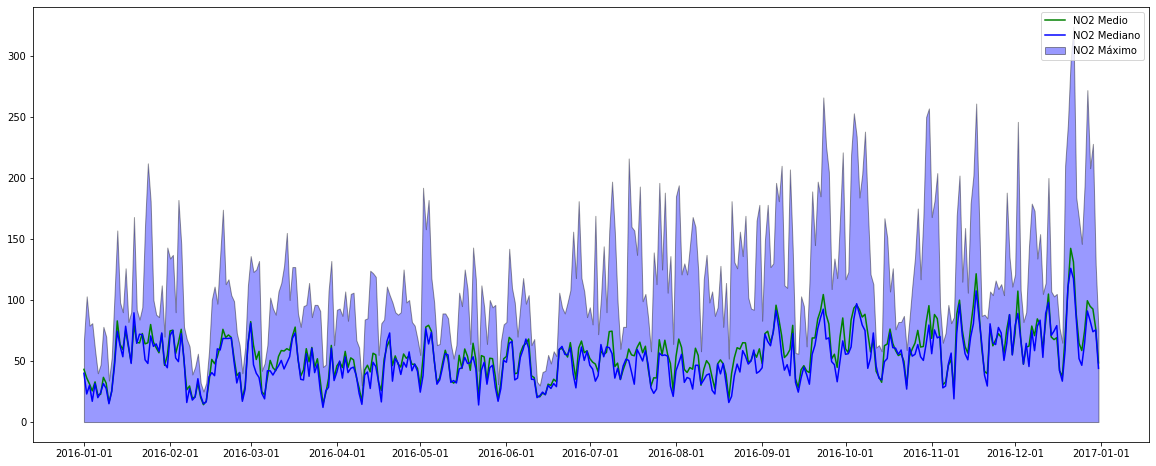

In [5]:
matplotlib.rcParams['figure.figsize'] = (20.0, 8.0)

x_values = [datetime.strptime(d,"%Y-%m-%d").date() for d in df_model['Fecha']]
y1_values = df_model['NO2_medio']
y2_values = df_model['NO2_mediano']
y3_values = df_model['NO2_maximo']
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
locator = mdates.DayLocator(bymonthday=1)
ax.xaxis.set_major_locator(locator)
plt.plot(x_values, y1_values, color='green', label='NO2 Medio')
plt.plot(x_values, y2_values, color='blue', label='NO2 Mediano')
plt.fill_between(x_values, y3_values, facecolor='blue', alpha=0.4, edgecolor='black', label='NO2 Máximo')
plt.legend(loc="upper right")
print(np.std(df_model['NO2_medio']))
print(np.std(df_model['NO2_mediano']))
print(np.std(df_model['NO2_maximo']))

Text(0.5, 1.0, 'Correlation for variableNO2_medio')

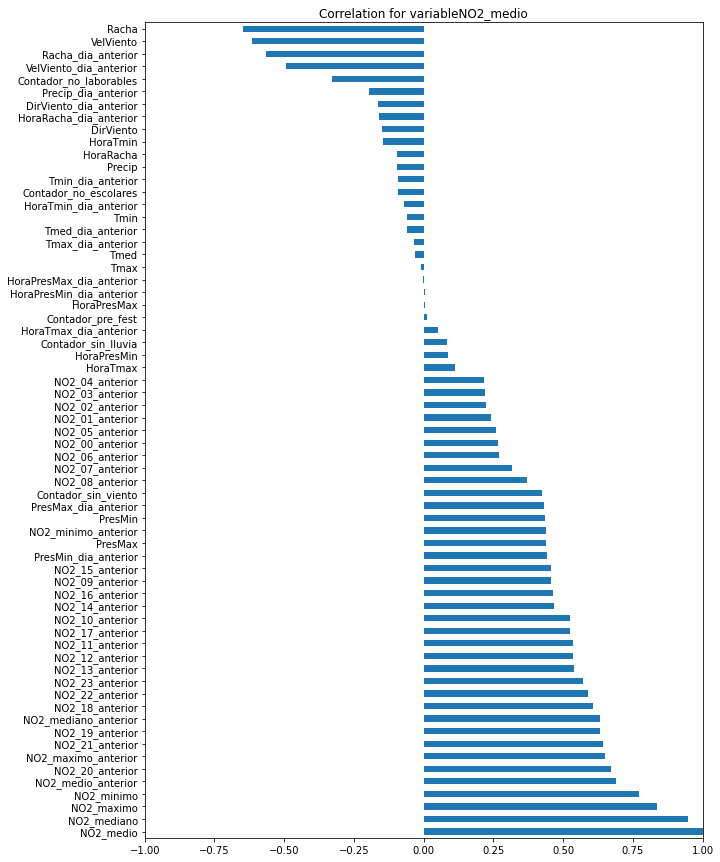

In [6]:
var_corr = 'NO2_medio'
matplotlib.rcParams['figure.figsize'] = (10.0, 15.0)
df_model.corr()[var_corr].sort_values(ascending=False).plot(kind='barh')
plt.xlim(-1, 1)
plt.title("Correlation for variable" + var_corr)

Text(0.5, 1.0, 'Correlation for variableNO2_mediano')

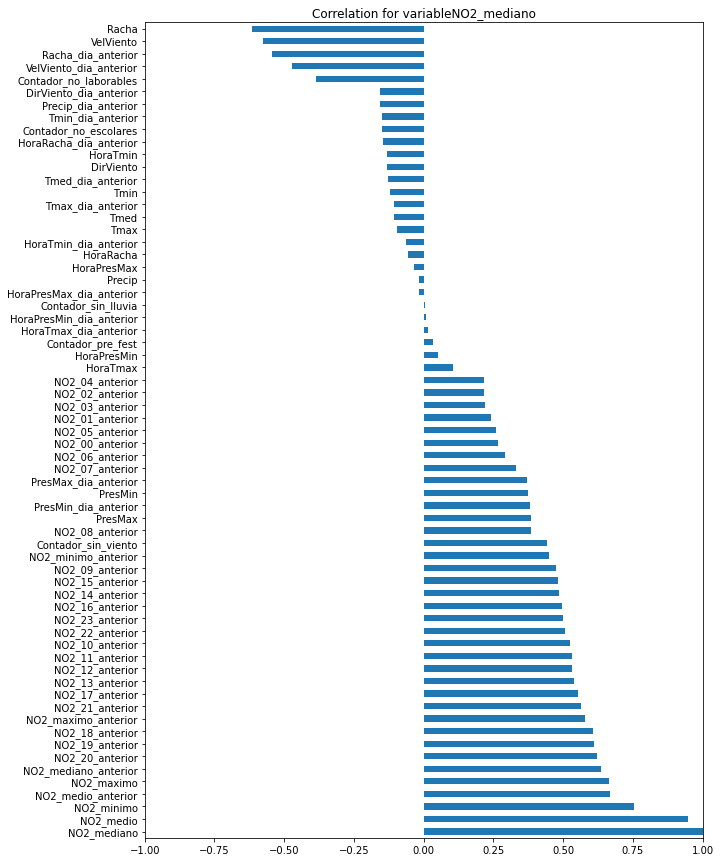

In [7]:
var_corr = 'NO2_mediano'
matplotlib.rcParams['figure.figsize'] = (10.0, 15.0)
df_model.corr()[var_corr].sort_values(ascending=False).plot(kind='barh')
plt.xlim(-1, 1)
plt.title("Correlation for variable" + var_corr)

Text(0.5, 1.0, 'Correlation for variableNO2_maximo')

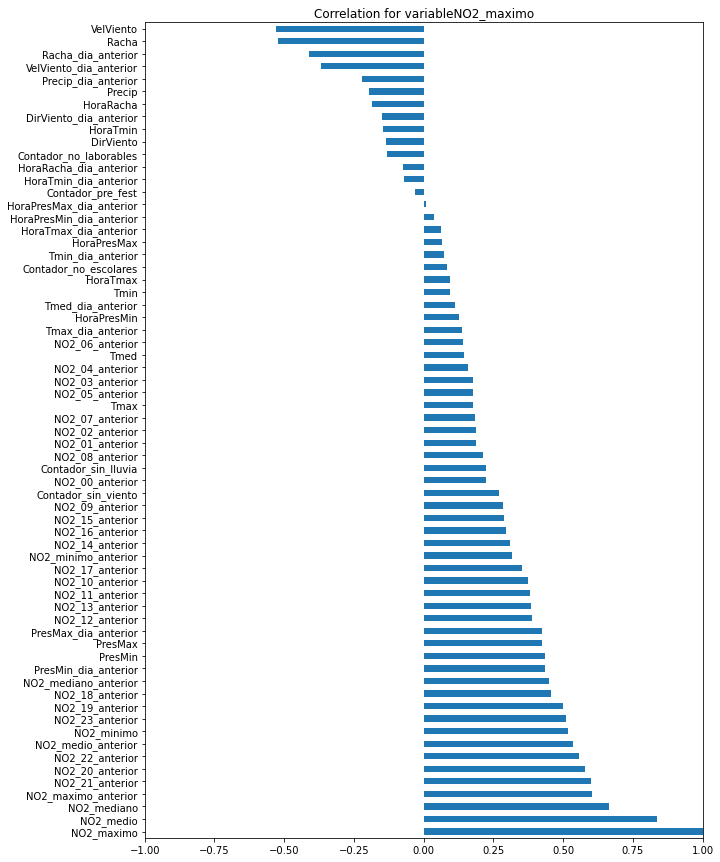

In [8]:
var_corr = 'NO2_maximo'
matplotlib.rcParams['figure.figsize'] = (10.0, 15.0)
df_model.corr()[var_corr].sort_values(ascending=False).plot(kind='barh')
plt.xlim(-1, 1)
plt.title("Correlation for variable" + var_corr)

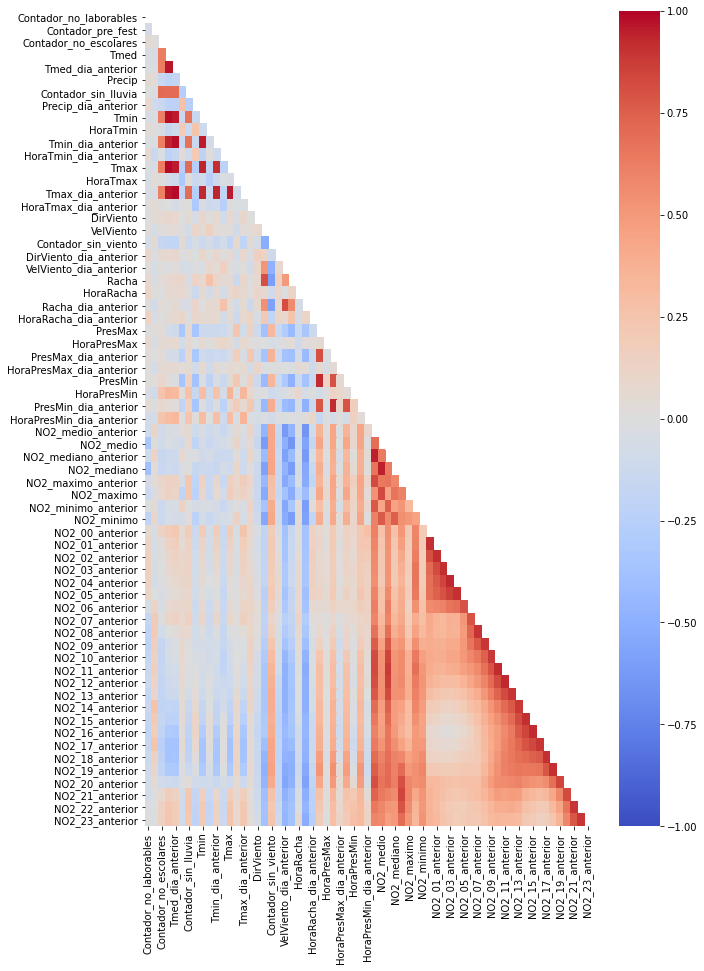

In [9]:
# Correlaciones
modelCorr = np.triu(df_model.corr())
sns.heatmap(df_model.corr(), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=modelCorr,  square=False)

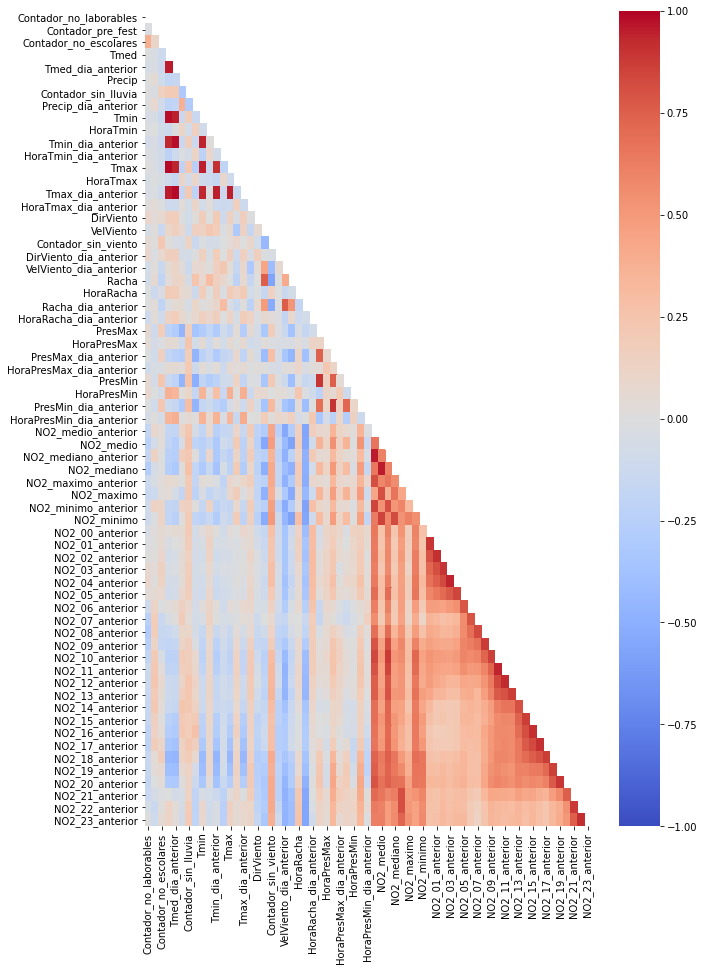

In [10]:
testCorr = np.triu(df_test.corr())
sns.heatmap(df_test.corr(), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=testCorr,  square=False)

In [11]:
for i,var in enumerate(df_model.corr().columns):
    mv = df_model.corr().iloc[i+1:][var]
    mv_related = mv[(mv > 0.9) | (mv < -0.9)]
    if len(mv_related) > 0:
        print(var+":")
        print("--------------------------")
        print(mv_related)
        print("")

Tmed:
--------------------------
Tmed_dia_anterior    0.968599
Tmin                 0.979507
Tmin_dia_anterior    0.944438
Tmax                 0.989426
Tmax_dia_anterior    0.961356
Name: Tmed, dtype: float64

Tmed_dia_anterior:
--------------------------
Tmin                 0.955728
Tmin_dia_anterior    0.979253
Tmax                 0.953321
Tmax_dia_anterior    0.989318
Name: Tmed_dia_anterior, dtype: float64

Tmin:
--------------------------
Tmin_dia_anterior    0.954953
Tmax                 0.939978
Tmax_dia_anterior    0.931894
Name: Tmin, dtype: float64

Tmin_dia_anterior:
--------------------------
Tmax                 0.912902
Tmax_dia_anterior    0.939293
Name: Tmin_dia_anterior, dtype: float64

Tmax:
--------------------------
Tmax_dia_anterior    0.958234
Name: Tmax, dtype: float64

PresMax:
--------------------------
PresMin    0.926573
Name: PresMax, dtype: float64

PresMax_dia_anterior:
--------------------------
PresMin_dia_anterior    0.925635
Name: PresMax_dia_anteri

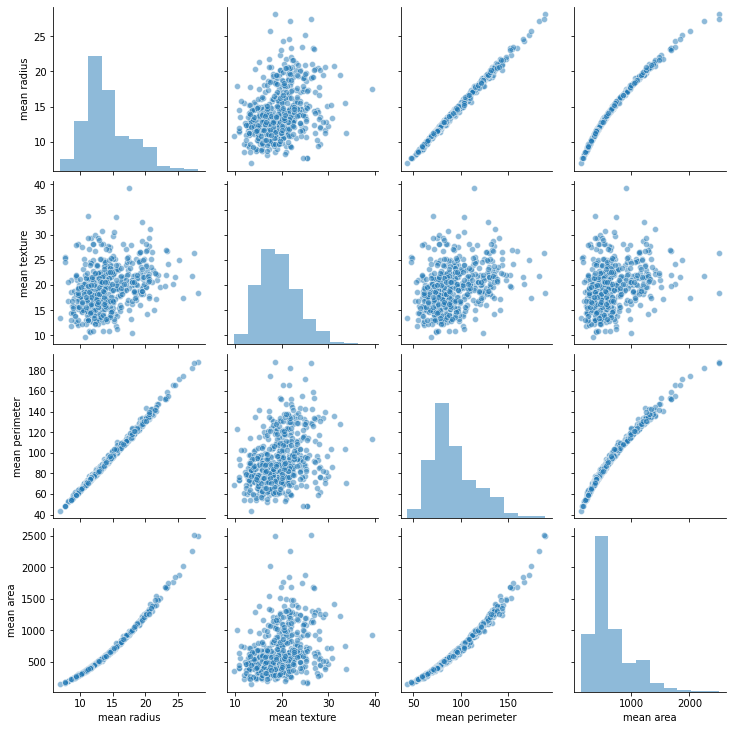

In [12]:
from sklearn.datasets import load_breast_cancer
data  = load_breast_cancer(return_X_y=False)

import pandas as pd

df=pd.DataFrame(data.data[:,:5])
df.columns = data.feature_names[:5]



import seaborn as sns;
import matplotlib.pyplot as plt
g= sns.pairplot(df, diag_kind= 'hist', 
             vars=df.columns[:-1],
             plot_kws=dict(alpha=0.5), 
             diag_kws=dict(alpha=0.5))
plt.show()

### Limpieza

In [0]:
# Eliminamos algunas columnas: las de NO2 del mismo dia, ya que no las tendremos en la prediccion
# tambien otras columnas irrelevantes o que introducen ruido

# Estaciones y NO2 del mismo dia
df_model.drop(['Estacion_clima', 'Estacion_contaminacion', 'NO2_mediano', 'NO2_maximo', 'NO2_minimo'], axis=1, inplace=True)

# Horas donde se producen valores maximos, minimos
df_model.drop(['HoraTmin', 'HoraTmax', 'HoraRacha', 'HoraPresMax', 'HoraPresMin', 'HoraTmin_dia_anterior', 'HoraTmax_dia_anterior', 'HoraRacha_dia_anterior', 'HoraPresMax_dia_anterior', 'HoraPresMin_dia_anterior'], axis=1, inplace=True)

# temperaturas
# df_model.drop(['Tmed', 'Tmin', 'Tmax'], axis=1, inplace=True)

# Viento
# df_model.drop(['DirViento', 'VelViento', 'Racha'], axis=1, inplace=True)

# presion
# df_model.drop(['PresMax', 'PresMin'], axis=1, inplace=True)

In [0]:
# Estaciones y NO2 del mismo dia
df_test.drop(['Estacion_clima', 'Estacion_contaminacion', 'NO2_mediano', 'NO2_maximo', 'NO2_minimo'], axis=1, inplace=True)

# Horas donde se producen valores maximos, minimos
df_test.drop(['HoraTmin', 'HoraTmax', 'HoraRacha', 'HoraPresMax', 'HoraPresMin', 'HoraTmin_dia_anterior', 'HoraTmax_dia_anterior', 'HoraRacha_dia_anterior', 'HoraPresMax_dia_anterior', 'HoraPresMin_dia_anterior'], axis=1, inplace=True)

# temperaturas
# df_test.drop(['Tmed', 'Tmin', 'Tmax'], axis=1, inplace=True)

# Viento
# df_test.drop(['DirViento', 'VelViento', 'Racha'], axis=1, inplace=True)

# presion
# df_test.drop(['PresMax', 'PresMin'], axis=1, inplace=True)

In [0]:
# Guardamos las fechas para obtener un dataframe resultado de la forma: fecha/valor real/prediccion

df_fecha = pd.DataFrame()
df_fecha = df_test[['Fecha']].copy()

In [0]:
# Obtenemos los dummies

df_model = pd.get_dummies(df_model, columns=['Estaciones_Anio', 'Mes', 'Dia_Semana', 'Fin_Semana', 'Festivo', 'Laborable', 'Pre_festivo', 'Escolar', 'Festivo_escolar', 'LLuvia', 'NivelViento'])

In [0]:
df_test = pd.get_dummies(df_test, columns=['Estaciones_Anio', 'Mes', 'Dia_Semana', 'Fin_Semana', 'Festivo', 'Laborable', 'Pre_festivo', 'Escolar', 'Festivo_escolar', 'LLuvia', 'NivelViento'])

In [0]:
# Eliminamos mas columnas que introducen ruido

df_model.drop(['PresMax', 'PresMax_dia_anterior', 'PresMin', 'PresMin_dia_anterior'], axis=1, inplace=True)
df_test.drop(['PresMax', 'PresMax_dia_anterior', 'PresMin', 'PresMin_dia_anterior'], axis=1, inplace=True)

In [0]:
# Completamos el dataframe test

df_test['Estaciones_Anio_Otono'] = 0
df_test['Mes_julio'] = 0
df_test['Mes_agosto'] = 0
df_test['Mes_septiembre'] = 0
df_test['Mes_octubre'] = 0
df_test['Mes_noviembre'] = 0
df_test['Mes_diciembre'] = 0

In [0]:
# Guardamos la columna target
no2_model = df_model['NO2_medio']
no2_test = df_test['NO2_medio']

### Preparación de datasets para algoritmos de ML
Tomamos los datos de 2016 como datos de entrenamiento, y los de 2017 como datos de test. En este caso, esta proporción 50/50, frente a otras proporciones que se suelen utilizar, es aconsejable debido al comportamiento estacional (no sólo semanal, sino sobre todo anual a causa de las estaciones del año) aconseja esta división.

# Predicciones

In [0]:
# Ridge
def pred_ridge(X_train, y_train, X_test, y_test, name):
    ridgeret = linear_model.Ridge() 
    grid = GridSearchCV(ridgeret,parametros,scoring='neg_mean_squared_error')
    grid.fit(X_train,y_train)
    alfa_ridge=grid.best_params_['alpha']

    # # Instantiate model
    ridgeret = linear_model.Ridge(alpha=alfa_ridge) 
    # ridgeret = linear_model.RidgeCV()

    # # Fit Model
    ridgeret.fit(X_train,y_train)

    # # Predict
    y_pred_ridge = ridgeret.predict(X_test)

    results['Ridge_'+(str(name))] = y_pred_ridge

    scores.loc[('Ridge'), ('R2_'+(str(name)))] = "{0:.6f}".format(metrics.r2_score(y_test, y_pred_ridge))
    scores.loc[('Ridge'), ('RMSE_'+(str(name)))] = "{0:.6f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge)))

In [0]:
# RandomForestRegressor
def pred_RF(X_train, y_train, X_test, y_test, name):
    # Instantiate mode
    # RF = RandomForestRegressor()
    RF = RandomForestRegressor(n_estimators=100, criterion='mse')

    # Fit Model
    RF.fit(X_train,y_train)

    # Predict
    y_pred_RF = RF.predict(X_test)

    # print("Features sorted by their score:")
    # print(sorted(zip(map(lambda x: round(x, 4), RF.feature_importances_), X_train.columns), reverse=True))

    results['RF_'+(str(name))] = y_pred_RF
    scores.loc[('RF'), ('R2_'+(str(name)))] = "{0:.6f}".format(metrics.r2_score(y_test, y_pred_RF))
    scores.loc[('RF'), ('RMSE_'+(str(name)))] = "{0:.6f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF)))

In [0]:
def prediction(X_train, y_train, X_test, y_test, name):
    pred_ridge(X_train, y_train, X_test, y_test, name)
    pred_RF(X_train, y_train, X_test, y_test, name)

In [0]:
# prediccion con NO2, clima e informacion de la fecha

In [0]:
df_model.drop('Fecha', axis=1, inplace=True)
df_test.drop('Fecha', axis=1, inplace=True)

# Split data
X_train = df_model.drop('NO2_medio', axis=1)
y_train = df_model['NO2_medio'].values

X_test =  df_test.drop('NO2_medio', axis=1)
y_test = df_test['NO2_medio'].values

parametros = { 'alpha': np.arange(0, 50, 1)}

results = pd.DataFrame()
scores = pd.DataFrame(index=['Ridge', 'RF'])
results['Test'] = y_test

prediction(X_train, y_train, X_test, y_test, 'all')

In [0]:
# prediccion con clima e informacion de la fecha

In [0]:
# Sin las variables de contaminacion:
df_model.drop([col for col in df_model.columns if "NO2" in col], axis=1, inplace=True)
df_test.drop([col for col in df_test.columns if "NO2" in col], axis=1, inplace=True)

df_model['NO2_medio'] = no2_model
df_test['NO2_medio'] = no2_test

In [0]:
# Split data
X_train = df_model.drop('NO2_medio', axis=1)
y_train = df_model['NO2_medio'].values

X_test =  df_test.drop('NO2_medio', axis=1)
y_test = df_test['NO2_medio'].values

# prediccion con clima y fecha
prediction(X_train, y_train, X_test, y_test, 'cl_date')

In [0]:
# Sin las variables de la fecha
contlluvia_model = df_model['Contador_sin_lluvia']
contlluvia_test = df_test['Contador_sin_lluvia']
contviento_model = df_model['Contador_sin_viento']
contviento_test = df_test['Contador_sin_viento']

df_model.drop([col for col in df_model.columns if "Contador" in col], axis=1, inplace=True)
df_test.drop([col for col in df_test.columns if "Contador" in col], axis=1, inplace=True)
df_model.drop([col for col in df_model.columns if "Estaciones" in col], axis=1, inplace=True)
df_test.drop([col for col in df_test.columns if "Estaciones" in col], axis=1, inplace=True)
df_model.drop([col for col in df_model.columns if "Mes" in col], axis=1, inplace=True)
df_test.drop([col for col in df_test.columns if "Mes" in col], axis=1, inplace=True)
df_model.drop([col for col in df_model.columns if "Semana" in col], axis=1, inplace=True)
df_test.drop([col for col in df_test.columns if "Semana" in col], axis=1, inplace=True)
df_model.drop([col for col in df_model.columns if "estivo" in col], axis=1, inplace=True)
df_test.drop([col for col in df_test.columns if "estivo" in col], axis=1, inplace=True)
df_model.drop([col for col in df_model.columns if "Laborable" in col], axis=1, inplace=True)
df_test.drop([col for col in df_test.columns if "Laborable" in col], axis=1, inplace=True)

df_model['Contador_sin_lluvia'] = contlluvia_model
df_test['Contador_sin_lluvia'] = contlluvia_test
df_model['Contador_sin_viento'] = contviento_model
df_test['Contador_sin_viento'] = contviento_test

In [0]:
# Split data
X_train = df_model.drop('NO2_medio', axis=1)
y_train = df_model['NO2_medio'].values

X_test =  df_test.drop('NO2_medio', axis=1)
y_test = df_test['NO2_medio'].values

# prediccion con clima
prediction(X_train, y_train, X_test, y_test, 'cl')

In [31]:
# Puntuaciones
scores

,R2_all,RMSE_all,R2_cl_date,RMSE_cl_date,R2_cl,RMSE_cl
Ridge,0.693761,11.337648,0.244003,17.813644,0.497966,14.516412
RF,0.704765,11.132091,0.502036,14.457447,0.506212,14.396695


In [32]:
# Obtenemos el df resultado
results = pd.merge(df_fecha, results, left_index=True, right_index=True)
results = results.sort_index()
results

,Fecha,Test,Ridge_all,RF_all,Ridge_cl_date,RF_cl_date,Ridge_cl,RF_cl
0,2017-01-01,48.000000,60.420997,60.233812,79.831461,82.130334,83.076185,94.083668
1,2017-01-02,57.541667,67.405200,70.608839,85.100725,91.788511,77.016467,87.873408
2,2017-01-03,76.848512,76.401119,67.482979,88.704410,91.667607,81.129158,81.812943
3,2017-01-04,72.875000,85.195251,85.862657,88.357060,90.424220,78.255764,86.975443
4,2017-01-05,70.250000,69.513711,65.188596,79.183293,91.359590,77.063483,82.110423
...,...,...,...,...,...,...,...,...
176,2017-06-26,41.916667,50.114584,40.881420,49.982996,33.713750,29.153290,34.395483
177,2017-06-27,51.083333,41.262093,48.098790,44.899523,31.898778,31.673604,25.902934
178,2017-06-28,16.375000,25.466864,26.561215,33.520515,25.708461,23.545939,22.584390
179,2017-06-29,24.083333,27.632159,25.119302,34.660479,28.153897,21.632075,26.287651


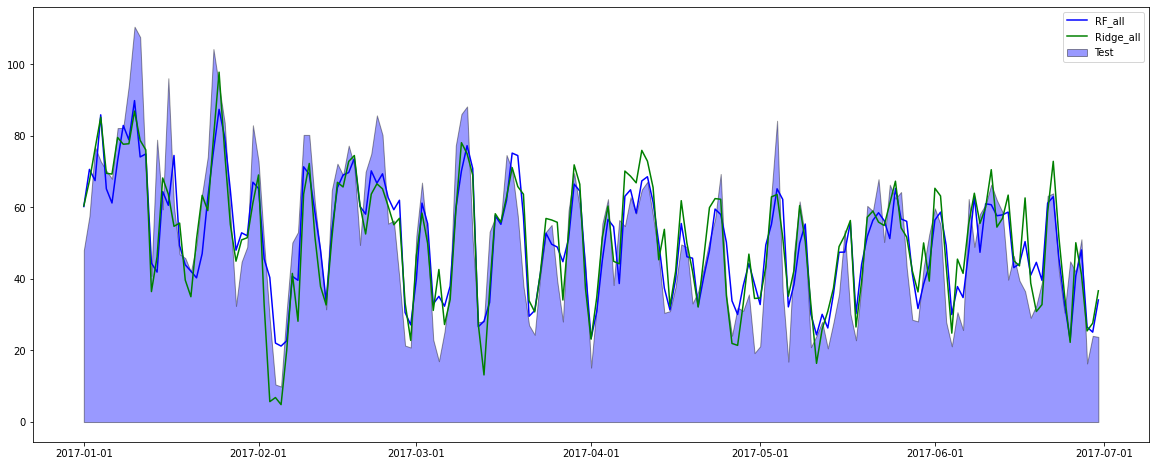

In [35]:
matplotlib.rcParams['figure.figsize'] = (20.0, 8.0)

x_values = [datetime.strptime(d,"%Y-%m-%d").date() for d in results['Fecha']]
y1_values = results['Test']
y3_values = results['Ridge_all']
y4_values = results['RF_all']
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
locator = mdates.DayLocator(bymonthday=1)
ax.xaxis.set_major_locator(locator)
plt.plot(x_values, y4_values, color='blue', label='RF_all')
plt.plot(x_values, y3_values, color='green', label='Ridge_all')
plt.fill_between(x_values, y1_values, facecolor='blue', alpha=0.4, edgecolor='black', label='Test')
plt.legend(loc="upper right")
#print(np.std(df_model['Test']))
#print(np.std(df_model['Lasso_all']))
#print(np.std(df_model['Ridge_all']))